In [33]:
from utils.kanhon_utils import *
import pandas as pd
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
from utils.lta_omv_scraper import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
orig_df = pd.read_csv(r"./dataset/train.csv")

# clean model
orig_df['model'] = orig_df['model'].apply(lambda x:x.replace('(', ''))
orig_df['reg_date_dt'] = orig_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
orig_df['reg_date_year'] = orig_df['reg_date_dt'].apply(lambda x:x.year)
orig_df['reg_date_month'] = orig_df['reg_date_dt'].apply(lambda x:x.month)

In [35]:
train_df, val_df = train_test_split(orig_df, test_size=0.2, random_state=42, shuffle=True)

### Imputation using LTA formula

In [36]:
from datetime import datetime

def calculate_arf(omv, reg_date, veh_type):
    if veh_type not in ['suv', 'luxury sedan', 'sports car', 'mid-sized sedan', 'hatchback', 'mpv', 'stationwagon']:
        return omv * 0.05
    # Define the cutoff date for the new ARF rates
    cutoff_date = datetime(2023, 2, 15)
    
    # Convert reg_date to a datetime object
    # reg_date = datetime.strptime(reg_date, "%Y-%m-%d")

    # Check if the car registration is before or after the cutoff date
    if reg_date < cutoff_date:
        # ARF rates for cars registered before the second COE bidding exercise in Feb 2023
        if omv <= 20000:
            arf = omv * 1.00
        elif omv <= 50000:
            arf = (20000 * 1.00) + ((omv - 20000) * 1.40)
        elif omv <= 80000:
            arf = (20000 * 1.00) + (30000 * 1.40) + ((omv - 50000) * 1.80)
        else:
            arf = (20000 * 1.00) + (30000 * 1.40) + (30000 * 1.80) + ((omv - 80000) * 2.20)
    else:
        # ARF rates for cars registered on or after the second COE bidding exercise in Feb 2023
        if omv <= 20000:
            arf = omv * 1.00
        elif omv <= 40000:
            arf = (20000 * 1.00) + ((omv - 20000) * 1.40)
        elif omv <= 60000:
            arf = (20000 * 1.00) + (20000 * 1.40) + ((omv - 40000) * 1.90)
        elif omv <= 80000:
            arf = (20000 * 1.00) + (20000 * 1.40) + (20000 * 1.90) + ((omv - 60000) * 2.50)
        else:
            arf = (20000 * 1.00) + (20000 * 1.40) + (20000 * 1.90) + (20000 * 2.50) + ((omv - 80000) * 3.20)

    return arf

# Example usage
omv = 285373.0  # Example OMV
reg_date = datetime(2023, 1, 15) # Example registration date
arf = calculate_arf(omv, reg_date, 'suv')
print(f"The ARF for OMV of ${omv} and registration date {reg_date} is ${arf:.2f}")


The ARF for OMV of $285373.0 and registration date 2023-01-15 00:00:00 is $567820.60


In [37]:
train_df['arf_impute_formula'] = train_df.apply(lambda x: calculate_arf(x['omv'], x['reg_date_dt'], x['type_of_vehicle']), axis=1)

In [38]:
train_df['arf_fillna'] = train_df['arf'].fillna(train_df['arf_impute_formula'])

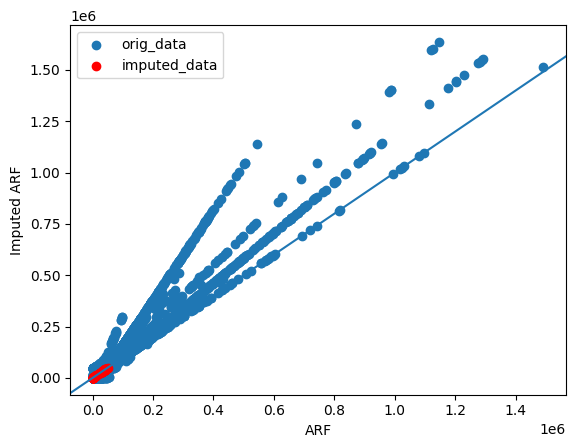

In [39]:
plt.scatter(train_df['arf'], train_df['arf_impute_formula'])
plt.scatter(train_df[train_df['arf'].isna()]['arf_fillna'], train_df[train_df['arf'].isna()]['arf_impute_formula'], color='r')
plt.legend(['orig_data', 'imputed_data']) 

plt.xlabel("ARF")
plt.ylabel("Imputed ARF")
plt.axline((0, 0), slope=1)
plt.show()

### KNNImputer

In [8]:
from sklearn.impute import KNNImputer, SimpleImputer
pd.set_option('display.max_columns', None)
from utils.melissa_utils import generic_one_hotencoding, vehicle_type_fit_transform, vehicle_type_fit
from utils.kanhon_utils import LTADataImputer, EmissionImputer
import os

In [9]:
# impute omv data
csv_filename = r'./dataset/lta_omv_data.csv'

if os.path.exists(csv_filename):
    df_lta_car_data = pd.read_csv(csv_filename)
else:
    result_ls = get_lta_omv_data(2002, 2025)
    df_lta_car_data = preprocess_lta_omv_data(result_ls)
    df_lta_car_data.to_csv(csv_filename)
lta_data_imputer = LTADataImputer(df_lta_car_data)

train_df = lta_data_imputer.transform(train_df) # before transform: 49 rows missing, after transform: 24 rows missing
val_df = lta_data_imputer.transform(val_df) # before transform: 15 rows missing, after transform: 9 rows missing

imputer = SimpleImputer(strategy='median')
train_df['omv'] = imputer.fit_transform(train_df[['omv']])
val_df['omv'] = imputer.transform(val_df[['omv']])
train_df , vehicle_type_encoder = vehicle_type_fit_transform(train_df, "type_of_vehicle")
val_df = vehicle_type_fit(val_df, vehicle_type_encoder)
# test_df = vehicle_type_fit(test_df, vehicle_type_encoder)

In [11]:
# KNN imputer
# Select features relevant for imputation
features = ['manufactured', 'reg_date_year', 'omv', 'arf', 'type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback',
       'type_of_vehicle_luxury sedan', 'type_of_vehicle_mid-sized sedan',
       'type_of_vehicle_mpv', 'type_of_vehicle_others',
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck', 'type_of_vehicle_van']

# Extract the subset of data for imputation
impute_df = train_df[features]

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Perform imputation
imputed_array = imputer.fit_transform(impute_df)

# Create a DataFrame from the imputed array
imputed_df = pd.DataFrame(imputed_array, columns=features)

# Add the imputed 'arf' values back to the original DataFrame
train_df['arf_impute'] = imputed_df['arf']

# Display the DataFrame with imputed values
print("\nDataFrame with Imputed ARF Values:")
print(train_df[['listing_id', 'omv', 'arf', 'arf_impute']])


DataFrame with Imputed ARF Values:
       listing_id       omv       arf  arf_impute
0         1260733   37994.0    1900.0      1900.0
1         1289505   14211.0   14211.0     14211.0
2         1316182   17199.0   17199.0     17199.0
3         1310514   22799.0   23919.0     23919.0
4         1247893   21074.0   21504.0     21504.0
...           ...       ...       ...         ...
19995     1330095   27677.0   25748.0     25748.0
19996     1300273   18974.0   13974.0     13974.0
19997     1316903   16213.0    6213.0      6213.0
19998     1329593  300022.0  512040.0    512040.0
19999     1321619   91730.0   91730.0     91730.0

[20000 rows x 4 columns]


In [21]:
train_df['arf_fillna'] = train_df['arf'].fillna(train_df['arf_impute'])

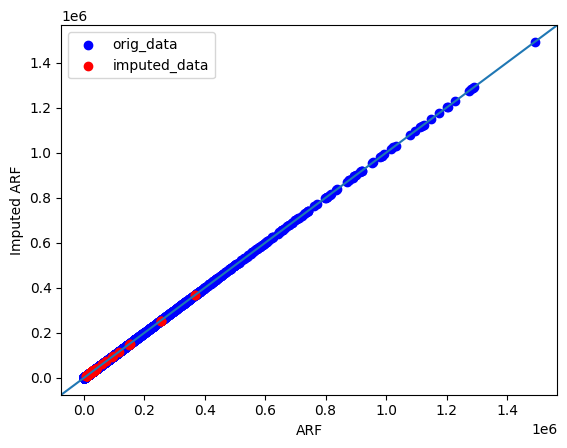

In [28]:
plt.scatter(train_df['arf'], train_df['arf_impute'], color='b')
plt.scatter(train_df[train_df['arf'].isna()]['arf_fillna'], train_df[train_df['arf'].isna()]['arf_impute'], color='r')
plt.legend(['orig_data', 'imputed_data']) 
plt.xlabel("ARF")
plt.ylabel("Imputed ARF")
plt.axline((0, 0), slope=1)
plt.show()

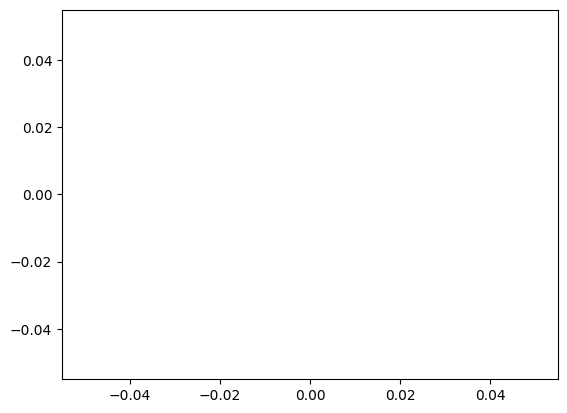

In [15]:
plt.scatter(train_df[train_df['arf'].isna()]['arf'], train_df[train_df['arf'].isna()]['arf_impute'])

### OMV

In [42]:
orig_df = pd.read_csv(r"./dataset/train.csv")
test_df = pd.read_csv(r"./dataset/test.csv")

# clean model
orig_df['model'] = orig_df['model'].apply(lambda x:x.replace('(', ''))
orig_df['reg_date_dt'] = orig_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
orig_df['reg_date_year'] = orig_df['reg_date_dt'].apply(lambda x:x.year)
orig_df['reg_date_month'] = orig_df['reg_date_dt'].apply(lambda x:x.month)

In [43]:
train_df, val_df = train_test_split(orig_df, test_size=0.2, random_state=42, shuffle=True)

In [44]:
make_df = pd.read_csv(r"./dataset/make.csv")
make_ls = [make.lower() for make in make_df['Make List'].unique()]

In [45]:
make_model_imputer = MakeModelImputer(make_ls)
train_df = make_model_imputer.transform(train_df)
val_df = make_model_imputer.transform(val_df) 
test_df = make_model_imputer.transform(test_df) 

In [46]:
csv_filename = r'./dataset/lta_omv_data.csv'
if os.path.exists(csv_filename):
    df_lta_car_data = pd.read_csv(csv_filename)
else:
    result_ls = get_lta_omv_data(2002, 2025)
    df_lta_car_data = preprocess_lta_omv_data(result_ls)
    df_lta_car_data.to_csv(csv_filename)


In [56]:
class LTADataImputer(BaseEstimator, TransformerMixin):
    def __init__(self, df_lta_car_data):
        self.df_lta_car_data = df_lta_car_data.copy()
    
    def fit(self, X, y=None):
        """
        No fitting necessary for this imputer.

        """
        return self
    
    def transform(self, X):
        X['omv_impute'] = X.apply(self._impute_using_lta_data, axis=1)
        return X


    def _impute_using_lta_data(self,row):
        # print(row)
        # if not np.isnan(row['omv']):
        #     return row['omv']
        # else:
        make = row['make']
        model = row['model']
        year = row['reg_date_year']
        lookup_by_make_model_year = self.df_lta_car_data[(self.df_lta_car_data['make_clean'] == make) & (self.df_lta_car_data['model_split'].str.contains(model)) & (self.df_lta_car_data['year'] == year)]
        
        lookup_by_make_model = self.df_lta_car_data[(self.df_lta_car_data['make_clean'] == make) & (self.df_lta_car_data['model_split'].str.contains(model))]

        lookup_by_make = self.df_lta_car_data[(self.df_lta_car_data['make_clean'] == make)]
        
        if not lookup_by_make_model_year.empty:
            # print('lookup_by_make_model_year')
            return lookup_by_make_model_year['omv_clean'].mean()
        elif not lookup_by_make_model.empty:
            # print('lookup_by_make_model')
            return lookup_by_make_model['omv_clean'].mean()
        elif not lookup_by_make.empty:
            # print('lookup_by_make')
            return lookup_by_make['omv_clean'].mean()
        else: 
            return None

In [57]:
lta_data_imputer = LTADataImputer(df_lta_car_data)

In [58]:
train_df = lta_data_imputer.transform(train_df) # before transform: 49 rows missing, after transform: 24 rows missing
val_df = lta_data_imputer.transform(val_df) # before transform: 15 rows missing, after transform: 9 rows missing


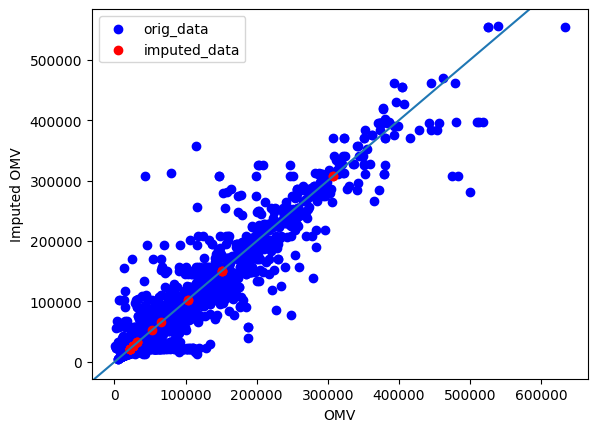

In [61]:
plt.scatter(train_df['omv'], train_df['omv_impute'], color='b')
plt.scatter(train_df[train_df['omv'].isna()]['omv_impute'], train_df[train_df['omv'].isna()]['omv_impute'], color='r')
plt.legend(['orig_data', 'imputed_data']) 
plt.xlabel("OMV")
plt.ylabel("Imputed OMV")
plt.axline((0, 0), slope=1)
plt.show()